# Multilabel algorithms over Kunisch P.  
## Seminario de Tesis I, Primavera 2022 
### MDS Program. University of Chile.
#### Supervisor: Prof. Benjamín Bustos, Prof. Iván Sipirán
#### Author: Matías Vergara

### References:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Mounting Google Drive



In [1]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    folder_path = 'drive/MyDrive/TesisMV/'
except:
    folder_path = '../'

In [2]:
import os
os.listdir(folder_path)

['.git',
 '.gitignore',
 '.idea',
 'actas',
 'features',
 'graficos',
 'labels',
 'models',
 'notebooks',
 'patterns',
 'presentaciones',
 'README.md',
 'requirements.txt']

## Define flags

In [3]:
#modify only this cell
USE_RN50 = False
DS_FLAGS = ['blur']
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 2
RANDOM_TIMES = 2
ELASTIC_TIMES = 2

In [4]:
# This cells builds the data_flags variable, that will be used
# to map the reques data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

labels_path = folder_path + "labels/" + data_flags + '/'
data_flags = f'resnet50_{data_flags}' if USE_RN50 else f'resnet18_{data_flags}'
features_path = folder_path + "features/" + data_flags + '/'

if not (os.path.isdir(features_path) and os.path.isdir(labels_path)):
    raise FileNotFoundError("No existen directorios de datos para el conjunto de flags seleccionado. Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation\n{}\n{}".format(features_path, labels_path))
print("Pattern set encontrado en {}".format(features_path))
print("Labels set encontrado en {}".format(labels_path))

Pattern set encontrado en ../features/resnet18_blur/
Labels set encontrado en ../labels/blur/


In [5]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from scipy import sparse

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing

In [7]:
features_train = pd.read_json(features_path + train_filename, orient='index').sort_index()
features_val = pd.read_json(features_path + val_filename, orient='index').sort_index()
features_test = pd.read_json(features_path + test_filename, orient='index').sort_index()

In [8]:
features_train

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
10a,0.014736,0.125330,0.018854,0.030200,0.039091,0.000000,0.001435,0.010765,0.006316,0.606860,...,0.000000,0.084091,0.190940,0.002154,0.029751,0.002110,0.020355,0.013152,0.000000,0.001350
10b,0.612503,0.073907,0.252336,0.023231,0.201091,0.005308,0.011826,0.339709,0.219701,1.145952,...,0.017813,0.002686,0.075442,0.219912,0.246503,0.030295,0.249666,0.150474,0.000269,0.009219
10c,0.001545,0.026830,0.003495,0.038163,0.116004,0.005194,0.023199,0.002206,0.040921,0.157558,...,0.004668,0.000733,0.059017,0.127050,0.013915,0.058213,0.013549,0.001259,0.000000,0.024122
10d,0.126646,0.033635,0.053828,0.039682,0.084399,0.007365,0.031973,0.090114,0.180799,0.206357,...,0.008742,0.007974,0.081458,0.118470,0.071872,0.020784,0.078801,0.050203,0.000000,0.005058
10e,0.866662,0.026251,0.454583,0.079493,0.353751,0.022633,0.053046,0.599426,0.565699,0.774769,...,0.040288,0.012901,0.058600,0.481664,0.444602,0.013475,0.413992,0.293495,0.000746,0.009119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9a,0.000233,0.110800,0.029298,0.018350,0.116571,0.000580,0.014139,0.002616,0.007588,0.659289,...,0.001894,0.000000,0.017293,0.071245,0.018831,0.000000,0.025131,0.006020,0.000235,0.030120
9b,0.000000,0.074883,0.007279,0.040537,0.055751,0.000515,0.008129,0.000676,0.004059,0.546095,...,0.000427,0.038941,0.090441,0.006165,0.026241,0.000000,0.005816,0.004867,0.000000,0.013107
9c,0.000000,0.035448,0.005390,0.047079,0.068894,0.000400,0.008184,0.000000,0.000111,0.377654,...,0.000292,0.011053,0.079914,0.015364,0.009570,0.000000,0.000000,0.000000,0.000000,0.048520
9d,0.000000,0.150171,0.000713,0.040673,0.068908,0.000969,0.000192,0.000000,0.046713,0.712962,...,0.000851,0.044159,0.061401,0.008409,0.004061,0.000515,0.003994,0.000000,0.000299,0.033140


In [9]:
features_val

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
12e,0.000675,0.021384,0.009508,0.130659,0.176664,0.021923,0.041816,0.000000,0.001207,0.034191,...,0.014938,0.127218,0.151919,0.125778,0.004485,0.000000,0.000000,0.000000,0.000169,0.002703
14c,0.000000,0.006481,0.030058,0.366645,0.069029,0.026293,0.019992,0.000000,0.017037,0.003466,...,0.000961,0.106836,0.054924,0.001040,0.008444,0.000000,0.000206,0.000000,0.000000,0.002683
14h,0.000567,0.040260,0.007942,0.128858,0.113617,0.015575,0.050926,0.000000,0.052290,0.074599,...,0.005316,0.062125,0.019902,0.046101,0.034148,0.009905,0.000000,0.000000,0.000072,0.017645
17f,0.000487,0.049844,0.001655,0.046913,0.055337,0.001175,0.025914,0.000000,0.009751,0.398384,...,0.002711,0.057449,0.028249,0.002330,0.020387,0.000000,0.000000,0.001283,0.000000,0.057391
19c,0.016763,0.014704,0.017989,0.132734,0.280137,0.035991,0.093018,0.024667,0.070463,0.027914,...,0.027633,0.014056,0.024049,0.248101,0.052947,0.004298,0.011966,0.015833,0.000372,0.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94c,0.001190,0.035819,0.014514,0.073391,0.125494,0.009124,0.027052,0.000900,0.000901,0.256565,...,0.004608,0.008297,0.002084,0.084509,0.000504,0.000642,0.000000,0.000000,0.000312,0.043222
95d,0.041363,0.036612,0.011792,0.006820,0.075070,0.000510,0.012668,0.067872,0.098164,0.331068,...,0.001283,0.038418,0.072722,0.029531,0.068533,0.000000,0.018802,0.047996,0.000000,0.011197
95h,0.006800,0.009064,0.011045,0.004201,0.017100,0.000000,0.002988,0.008908,0.051377,0.444457,...,0.001646,0.014164,0.065464,0.005547,0.042345,0.000256,0.013341,0.008761,0.000000,0.028882
95i,0.000000,0.043762,0.000000,0.019194,0.104575,0.000948,0.010304,0.000825,0.057951,0.426149,...,0.000934,0.028434,0.036214,0.025624,0.046920,0.000000,0.000000,0.004989,0.000000,0.041032


In [10]:
features_test

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
12e,0.000675,0.021384,0.009508,0.130659,0.176664,0.021923,0.041816,0.000000,0.001207,0.034191,...,0.014938,0.127218,0.151919,0.125778,0.004485,0.000000,0.000000,0.000000,0.000169,0.002703
14c,0.000000,0.006481,0.030058,0.366645,0.069029,0.026293,0.019992,0.000000,0.017037,0.003466,...,0.000961,0.106836,0.054924,0.001040,0.008444,0.000000,0.000206,0.000000,0.000000,0.002683
14h,0.000567,0.040260,0.007942,0.128858,0.113617,0.015575,0.050926,0.000000,0.052290,0.074599,...,0.005316,0.062125,0.019902,0.046101,0.034148,0.009905,0.000000,0.000000,0.000072,0.017645
17f,0.000487,0.049844,0.001655,0.046913,0.055337,0.001175,0.025914,0.000000,0.009751,0.398384,...,0.002711,0.057449,0.028249,0.002330,0.020387,0.000000,0.000000,0.001283,0.000000,0.057391
19c,0.016763,0.014704,0.017989,0.132734,0.280137,0.035991,0.093018,0.024667,0.070463,0.027914,...,0.027633,0.014056,0.024049,0.248101,0.052947,0.004298,0.011966,0.015833,0.000372,0.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94c,0.001190,0.035819,0.014514,0.073391,0.125494,0.009124,0.027052,0.000900,0.000901,0.256565,...,0.004608,0.008297,0.002084,0.084509,0.000504,0.000642,0.000000,0.000000,0.000312,0.043222
95d,0.041363,0.036612,0.011792,0.006820,0.075070,0.000510,0.012668,0.067872,0.098164,0.331068,...,0.001283,0.038418,0.072722,0.029531,0.068533,0.000000,0.018802,0.047996,0.000000,0.011197
95h,0.006800,0.009064,0.011045,0.004201,0.017100,0.000000,0.002988,0.008908,0.051377,0.444457,...,0.001646,0.014164,0.065464,0.005547,0.042345,0.000256,0.013341,0.008761,0.000000,0.028882
95i,0.000000,0.043762,0.000000,0.019194,0.104575,0.000948,0.010304,0.000825,0.057951,0.426149,...,0.000934,0.028434,0.036214,0.025624,0.046920,0.000000,0.000000,0.004989,0.000000,0.041032


In [8]:
labels_train = pd.read_json(labels_path + train_filename, orient='index').sort_index()
labels_val = pd.read_json(labels_path + val_filename, orient='index').sort_index()
labels_test = pd.read_json(labels_path + test_filename, orient='index').sort_index()

In [12]:
labels_train

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10d,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10e,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9a,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9b,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9c,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9d,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
labels_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
11a,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11e,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11j,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16g,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16m,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
91f,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
91g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
labels_test

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
12e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19c,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95d,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95h,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95i,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
def filter_labels(labels_df, freq):
  """Filters a label dataframe based on labels frequency (number of events)

    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > freq]
  top_labels = filtered_df.sum().sort_values(ascending=False)
  return top_labels

def filter_dfs(df, top_labels_df):
  df = df[df.columns.intersection(top_labels_df.index)]
  return df

def combine_dfs(labels_df, top_labels_df, features_df):
  """Combine labels dataframe with features dataframe based on index (patterns names)
     keeping only the most frequent labels.

    Parameters:
    labels_df (DataFrame): dataframe of labels, with patterns name as index
    top_labels_df (DataFrame): a 1D dataframe with the name of the most freq. labels, as 
    the outcome of filter_labels() function 
    features_df (DataFrame): dataframe of features, with patterns name as index 

    Returns:
    DataFrame: combined labels + features dataframe, merged on index

  """
  assert len(labels_df) == len(features_df)
  labels_df = labels_df[labels_df.columns.intersection(top_labels_df.index)]
  final_df = pd.merge(labels_df,       
                      features_df,  
                      left_index=True, right_index=True)
  return final_df

def split_data(final_df, top_labels_df, test_size):
  """Splits the data in train and test. 
    
    Parameters:
    final_df (DataFrame): outcome of combine_dfs.
    top_labels_df (DataFrame): dataframe of most freq. labels. Necessary to 
    know at which column the labels (Y) ends and the features (X) starts  
    freq (int): threshold frequency. Labels with a lower value will be filtered. 
    test_size (float): proportion test/(test+train).

    Returns:
    (np.array, np.array, np.array, np.array): X train, X test, Y train, Y test

  """
  X = np.array(final_df.iloc[:, len(final_df):], dtype=float)
  Y = np.array(final_df.iloc[:, 0:len(final_df)], dtype=float)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=42)
  return X_train, X_test, Y_train, Y_test

In [11]:
top_labels_df = filter_labels(labels_train, 90) # for example
top_labels_df

panel            698
horizontal       566
ornament         274
vertical         252
hatched          244
metopal          200
lozenge          200
filling          190
double           144
triangle         142
cross-hatched    132
meander          114
circle           110
chain            108
bar              102
concentric        96
enclosing         94
dtype: int64

# Data exploration

In [17]:
def get_unique_combinations(labels_df):
  """Returns the number of different combinations of labels in labels_df.

    Parameters:
    labels_df (DataFrame): dataframe of labels 

    Returns:
    int: number of unique labels combinations in labels_df
  """
  unique_combinations = len(labels_df.drop_duplicates())
  print("Number of unique labels combinations: " + str(unique_combinations))
  return unique_combinations

def get_label_metrics(labels_df):
  """Returns label cardinality and label density of a multilabel dataset.
     Label cardinality: average number of labels per entry 
     Label density: fraction of assigned labels over total num of labels,
                    averaged per entry
    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  sum_labels = labels_df.sum(axis=1)
  total_labels = labels_df.shape[0]
  label_cardinality = 0
  for label in sum_labels:
    label_cardinality += label/total_labels
  label_density = label_cardinality/total_labels
  print("Label cardinality: {}".format(label_cardinality))
  print("Label density: {}".format(label_density))
  return(label_cardinality, label_density)

print("Exploring train set")
combinations = get_unique_combinations(labels_train)
metrics = get_label_metrics(labels_train)

Exploring train set
Number of unique labels combinations: 480
Label cardinality: 5.3790322580645356
Label density: 0.008675858480749251


# Functions to run experiments and visualizations

In [18]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [19]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    clf_predictions = sparse.csr_matrix(clf_predictions)
    exact_match = accuracy_score(ytest,clf_predictions)
    ham_loss = hamming_loss(ytest,clf_predictions)
    ham_score = hamming_score(ytest.toarray(), clf_predictions.toarray())
    result = {"exact_match":exact_match,"hamming_loss": ham_loss, "hamming_score":ham_score}
    return result, clf_predictions

In [20]:
# Plotting linemarks
ALREADY_RUN = False 

# This code has to be executed only once in order to have the same linemarks in 
# each figure
if not ALREADY_RUN:
  import random
  linemark = []
  MARKERS = ['.','+','v','x','*']
  LINE_STYLES = ['-','--','-.',':']

  for i in range(0, 20): 
    linestyle = LINE_STYLES[random.randint(0, len(LINE_STYLES)-1)]
    marker = MARKERS[random.randint(0, len(MARKERS)-1)]
    linemark.append (linestyle + marker)
  
  ALREADY_RUN = True

In [21]:
  def plot_results(x, acc = [], loss = [], score=[], label=[], title = "",
                 xlabel = "", ylabel = "", plot_emr=False, plot_hl=False, plot_hs=True):
    """plots accuracy, hamming loss and hamming score of multiple classifiers.
    
    Returns:
    DataFrame: filtered labels dataframe

    """
    assert len(acc) == len(loss) == len(label)
    if plot_emr:
        f_acc = plt.figure(1)
        f_acc.set_figheight(9)
        f_acc.set_figwidth(7)
        ax1 = f_acc.add_subplot(111)
        ax1.set_title(title + "\n Exact Match Ratio")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_ylim(0, 1)
        for i in range(0, len(acc)):
          ax1.plot(x, acc[i],  linemark[i], label=label[i])
        ax1.legend()
        f_acc.show()
    if plot_hl:
        f_loss = plt.figure(2)
        f_loss.set_figheight(9)
        f_loss.set_figwidth(7)
        ax2 = f_loss.add_subplot(111)
        ax2.set_title(title  + "\n Hamming Loss")
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(ylabel)
        for i in range(0, len(loss)):
          ax2.plot(x, loss[i], linemark[i], label=label[i])
        ax2.legend()
        f_loss.show()

    if plot_hs:
        f_score = plt.figure(3)
        f_score.set_figheight(9)
        f_score.set_figwidth(7)
        ax3 = f_score.add_subplot(111)
        ax3.set_title(title  + "\n Hamming Score")
        ax3.set_xlabel(xlabel)
        ax3.set_ylabel(ylabel)
        ax3.set_ylim(0, 1)
        for i in range(0, len(score)):
          ax3.plot(x, score[i], linemark[i], label=label[i])
        ax3.legend()
        f_score.show()

In [22]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """
    Prints confusion matrix for multilabel classification.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

def plot_multiple_matrix(cfs_matrix, present_labels, nrows=24, ncols=5, figsize=(12,50), filename="results"):
  """
  Plots multiple confusion matrix

  Parameters:
  cfs_matrix (2D array): an array containing the multiple confusion matrix as
                         outcome of multilabel_confusion_matrix()
  present_labels (1D array): array of strings with name of labels, in the same
                             order as they are in cfs_matrix
  nrows, ncols, figsize: number of rows, columns and size of the plot
  
  """
  fig, ax = plt.subplots(24, 5, figsize=(12, 50))

  for axes, cfs_vals, label in zip(ax.flatten(), cfs_matrix, present_labels):
      print_confusion_matrix(cfs_vals, axes, label, ["N", "Y"])

  fig.tight_layout()
  plt.show()
  plt.savefig(filename + ".png")

# Benchmark


In [47]:
#MIN_FREQS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
#MIN_FREQS = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
MIN_FREQS = [30, 60, 120]

TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"MLkNN": mlknn} #, "MLTSVM": mltsvm, "BRkNN": brknna}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                    "SVC": svm.SVC()}#, "DT": tree.DecisionTreeClassifier()} # "GNB": GaussianNB()
exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss [meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss [meth_name] = []

for i in MIN_FREQS:
  print("Starting with i={}".format(i))
  # Dataset creation
  top_labels_i = filter_labels(labels_train, i)
  X_train = features_train
  X_test = features_test
  Y_train = filter_dfs(labels_train, top_labels_i) # reduce labels to most freq
  Y_test = filter_dfs(labels_test, top_labels_i) # in both train and test

  for meth_name, method in ADAPT_METHODS.items():
    output_i, predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
    exp_exact_match[meth_name].append(output_i['exact_match'])
    exp_hscore[meth_name].append(output_i['hamming_score'])
    exp_hloss[meth_name].append(output_i['hamming_loss'])

  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
    for base_name, classifier in BASE_CLASSIFIERS.items():
      output_i, _ = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
      exp_exact_match[meth_name + "_" + base_name].append(output_i['exact_match'])
      exp_hscore[meth_name + "_" + base_name].append(output_i['hamming_score'])
      exp_hloss[meth_name + "_" + base_name].append(output_i['hamming_loss'])


Starting with i=30


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

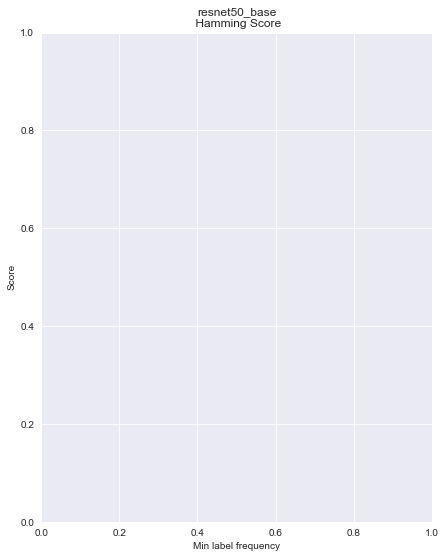

In [55]:
plot_results(MIN_FREQS,
             acc = list(exp_exact_match.values()),
             loss = list(exp_hloss.values()),
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [231]:
THRESHOLD = 30
METHOD = "LP" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "SVC" # | "SVC" | "DT" | "GNB" | "LR"

top_labels = filter_labels(labels_train, THRESHOLD)
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test
Y_test = filter_dfs(labels_test, top_labels)


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

print(data_flags)
print("HAMMING SCORE: {}".format(clf_model['hamming_score']))
predictions = predictions.toarray()
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test, 
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

resnet18_base
HAMMING SCORE: 0.24714590964590963
               precision    recall  f1-score   support

        panel       0.41      0.81      0.54        31
   horizontal       0.56      0.85      0.67        40
     ornament       0.25      0.18      0.21        11
     vertical       0.00      0.00      0.00         1
      hatched       0.00      0.00      0.00         2
      metopal       0.00      0.00      0.00         3
      lozenge       0.12      0.07      0.09        15
      filling       0.12      0.10      0.11        10
       double       0.00      0.00      0.00         1
     triangle       0.18      0.33      0.23         9
cross-hatched       0.26      0.29      0.27        21
      meander       0.00      0.00      0.00         1
       circle       0.00      0.00      0.00        12
        chain       0.00      0.00      0.00         4
          bar       0.00      0.00      0.00         0
   concentric       0.00      0.00      0.00         5
    enclosing  

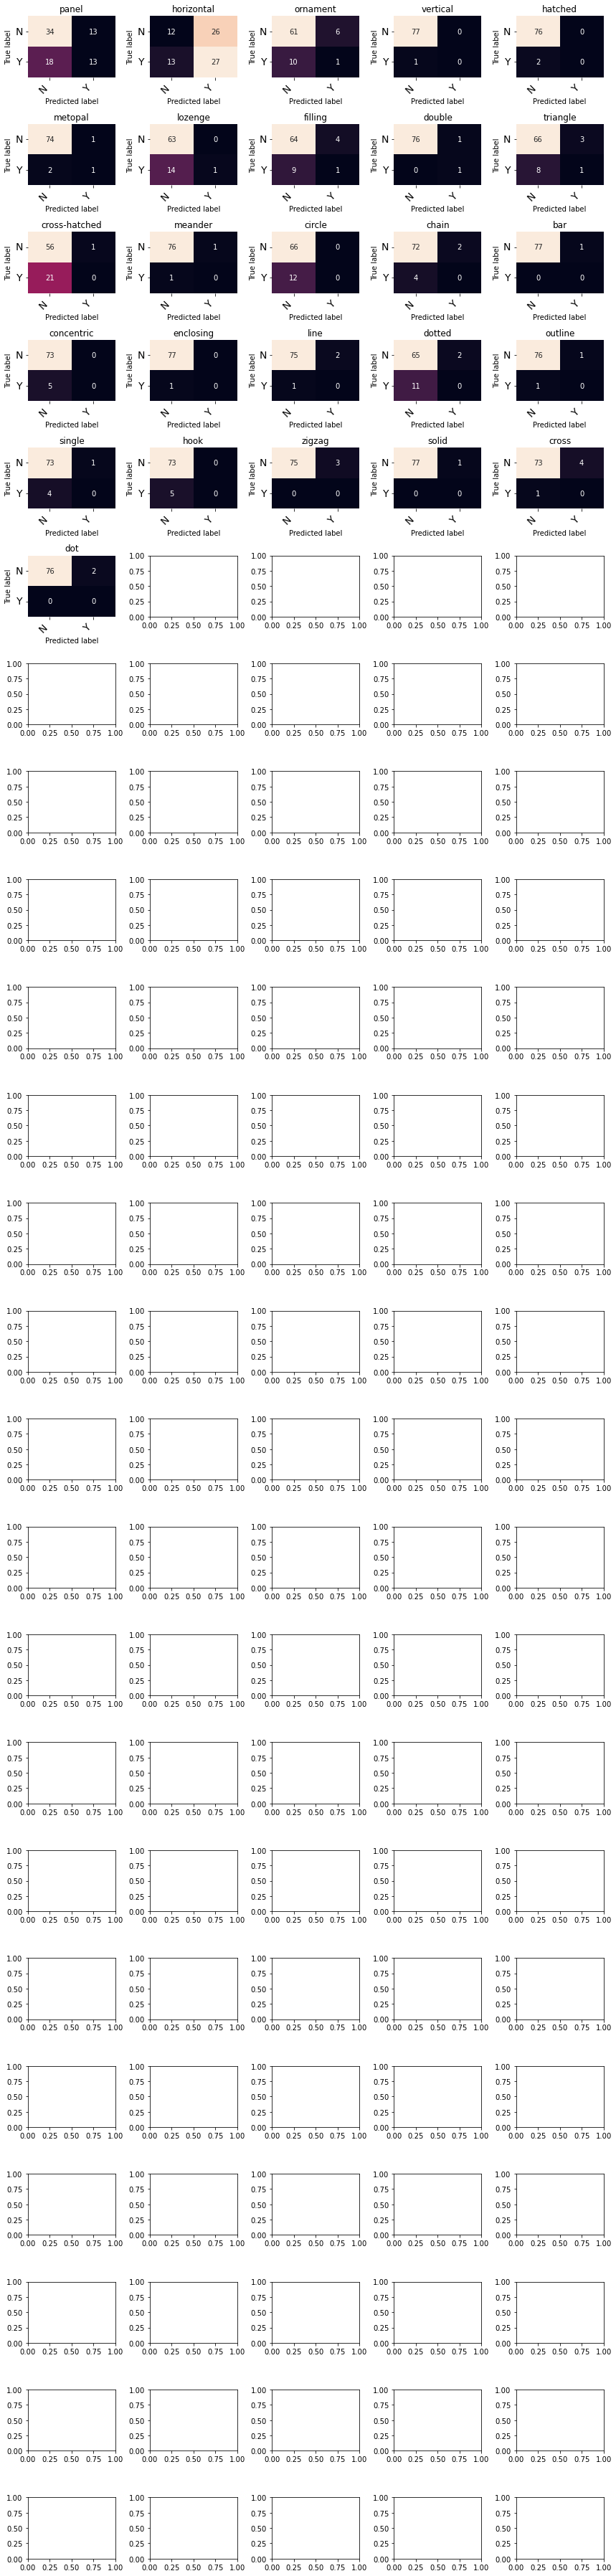

<Figure size 432x288 with 0 Axes>

In [61]:
plot_multiple_matrix(cfs_matrix, present_labels)

# Binary Relevance with handcrafted class balance

In [ ]:
def split_balanced(label, colnames, X_train, Y_train):
  """Generates a balanced train and test dataset for a given label

    Parameters:
    label (String): label on which the balanced dataset will be created 
    colnames (1D array): correspondance label_name - dataset_column
    X_train, Y_train (np arrays): original (potentially unbalanced) train datasets. 

    Returns:
    X_train, Y_train (np arrays): train datasets with equal number of positive and
                                  negative events for the given label. 

  """
  index_label = colnames.tolist().index(label)
  indexes_positives = []
  indexes_negatives = []
  for i in range(0, Y_train.shape[0]):
    if Y_train[i][index_label] == 1: 
      indexes_positives.append(i)
    else:
      indexes_negatives.append(i)
  indexes_negatives = indexes_negatives[0:len(indexes_positives)]
  final_indexes = indexes_positives + indexes_negatives
  final_indexes.sort()
  X_train = X_train[final_indexes, :]
  Y_train = Y_train [final_indexes, index_label]
  return X_train, Y_train

In [ ]:
base_classifiers = {}
TEST_SIZE = 0.2
THRESHOLD = 15

top_labels = filter_labels(labels_df, THRESHOLD)

filtered_X_train = filter_dfs(features_train, top_labels)
filtered_Y_train = filter_dfs(labels_train, top_labels)
filtered_X_test = filter_dfs(features_test, top_labels)
filtered_Y_test = filter_dfs(labels_test, top_labels)

X_train = sparse.csr_matrix(filtered_X_train.values)
Y_train = sparse.csr_matrix(filtered_Y_train.values)
X_test = sparse.csr_matrix(filtered_X_test.values)
Y_test = sparse.csr_matrix(filtered_Y_test.values)

predictions = []

for i in range(0, len(top_labels)):
  label = final.columns[i]
  bc = LogisticRegression(solver='lbfgs')
  X_train_label, Y_train_label = split_balanced(label, final.columns, X_train, Y_train) # tantos positivos como posible e igual a negativos
  bc.fit(X_train_label, Y_train_label)
  base_classifiers[label] = bc
  clf_prediction = bc.predict(X_test)
  predictions.append(clf_prediction) # una columna de prediccion

predictions = np.array(predictions).T

exact_match = accuracy_score(Y_test, predictions)
ham_loss = hamming_loss(Y_test, predictions)
ham_score = hamming_score(Y_test, predictions)

print("Exact match ratio: {}".format(exact_match))
print("Hamming loss: {}".format(ham_loss))
print("Hamming score: {}".format(ham_score))

Exact match ratio: 0.0
Hamming loss: 0.18391276373882368
Hamming score: 0.15940659518793746


In [ ]:
present_labels = top_labels.index
cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test, 
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

                         precision    recall  f1-score   support

                  panel       0.06      0.80      0.11        10
               ornament       0.82      0.94      0.88       177
             horizontal       0.78      0.90      0.83       222
                metopal       0.04      1.00      0.08         6
                hatched       0.54      0.89      0.67        61
                 circle       0.08      0.79      0.14        14
              enclosing       0.05      1.00      0.10         9
                filling       0.66      0.80      0.73       116
                lozenge       0.20      0.86      0.32        43
          cross-hatched       0.51      0.87      0.64       101
                 double       0.69      0.84      0.76       176
               vertical       0.06      1.00      0.11         7
               triangle       0.05      0.58      0.09        12
             concentric       0.13      0.61      0.21        41
                  cross 

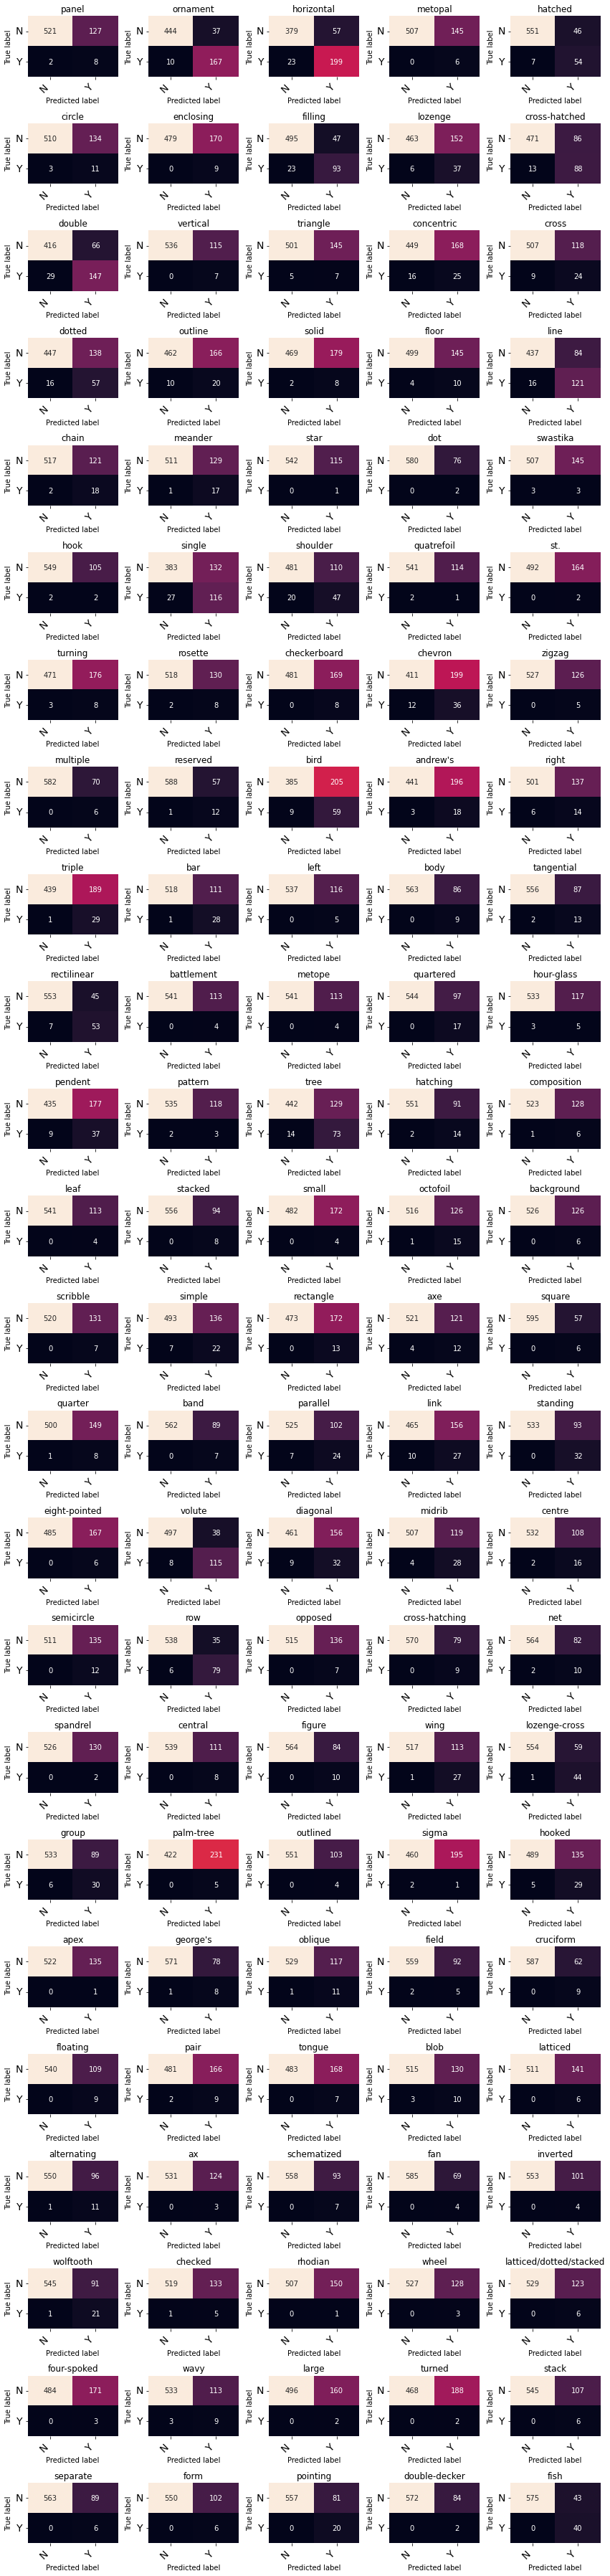

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_multiple_matrix(cfs_matrix, present_labels)